In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir pos_tagger

In [ ]:
cd pos_tagger

/content/pos_tagger


In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz -O - | gunzip | cut -f1,2 -d" " > pos.train.txt

--2021-04-23 11:36:26--  http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz [following]
--2021-04-23 11:36:27--  https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611540 (597K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 597.21K  1.35MB/s    in 0.4s    

2021-04-23 11:36:28 (1.35 MB/s) - written to stdout [611540/611540]



In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz -O - | gunzip | cut -f1,2 -d " " > pos.test.txt

--2021-04-23 11:36:28--  http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz [following]
--2021-04-23 11:36:28--  https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139551 (136K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 136.28K   528KB/s    in 0.3s    

2021-04-23 11:36:29 (528 KB/s) - written to stdout [139551/139551]



In [ ]:
!pip install torch-summary

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()[-1])

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10522677437694033306
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"



In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
import string
import re
import spacy

from collections import Counter

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
random_seed = 20
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.set_printoptions(threshold=2000)

In [ ]:
remove_tags = ['.',',','(',')',':','``',"''",'#','$']

In [ ]:
train_file = "pos.train.txt"
test_file = "pos.test.txt"

def create_dataset(filename):
    data = []
    label = []
    with open(filename, 'r') as f:
        x = []
        y = []
        for line in f:
            s = line.split()
            if s == []:
                data.append(" ".join(x))
                label.append(" ".join(y))
                x = []
                y = []
                continue
            x.append(s[0])
            if s[1] in remove_tags:
                y.append("PUN")
            else:
                y.append(s[1])
    return data, label

X_train, y_train_tags = create_dataset(train_file)
X_test, y_test_tags = create_dataset(test_file)

In [ ]:
for i in range(len(X_train)):
    assert(len(X_train[i].split()) == len(y_train_tags[i].split()))

In [ ]:
indx = 3

print(X_train[indx])
print(len(X_train[indx].split()))

print(y_train_tags[indx])
print(len(y_train_tags[indx].split()))

This has increased the risk of the government being forced to increase base rates to 16 % from their current 15 % level to defend the pound , economists and foreign exchange market analysts say .
36
DT VBZ VBN DT NN IN DT NN VBG VBN TO VB NN NNS TO CD NN IN PRP$ JJ CD NN NN TO VB DT NN PUN NNS CC JJ NN NN NNS VBP PUN
36


In [ ]:
POS_tags = {}
for line in y_train_tags:
    s = line.split()
    for elem in s:
        if elem not in POS_tags:
            POS_tags[elem] = 1
        else:
            POS_tags[elem] += 1
print(len(POS_tags))
print(POS_tags)

36
{'NN': 30147, 'IN': 22764, 'DT': 18335, 'VBZ': 4648, 'RB': 6607, 'VBN': 4763, 'TO': 5081, 'VB': 6017, 'JJ': 13085, 'NNS': 13619, 'NNP': 19884, 'PUN': 26009, 'CC': 5372, 'POS': 1769, 'VBP': 2868, 'VBG': 3272, 'PRP$': 1881, 'CD': 8315, 'VBD': 6745, 'EX': 206, 'MD': 2167, 'NNPS': 420, 'PRP': 3820, 'JJS': 374, 'WP': 529, 'RBR': 321, 'JJR': 853, 'WDT': 955, 'WRB': 478, 'RBS': 191, 'PDT': 55, 'RP': 83, 'FW': 38, 'WP$': 35, 'SYM': 6, 'UH': 15}


In [ ]:
tag_to_idx = {"<PAD>": 0}
idx_to_tag = {0: "<PAD>"}
for tag in POS_tags.keys():
    indx = len(tag_to_idx)
    tag_to_idx[tag] = indx
    idx_to_tag[indx] = tag
print(tag_to_idx)
print(idx_to_tag)

{'<PAD>': 0, 'NN': 1, 'IN': 2, 'DT': 3, 'VBZ': 4, 'RB': 5, 'VBN': 6, 'TO': 7, 'VB': 8, 'JJ': 9, 'NNS': 10, 'NNP': 11, 'PUN': 12, 'CC': 13, 'POS': 14, 'VBP': 15, 'VBG': 16, 'PRP$': 17, 'CD': 18, 'VBD': 19, 'EX': 20, 'MD': 21, 'NNPS': 22, 'PRP': 23, 'JJS': 24, 'WP': 25, 'RBR': 26, 'JJR': 27, 'WDT': 28, 'WRB': 29, 'RBS': 30, 'PDT': 31, 'RP': 32, 'FW': 33, 'WP$': 34, 'SYM': 35, 'UH': 36}
{0: '<PAD>', 1: 'NN', 2: 'IN', 3: 'DT', 4: 'VBZ', 5: 'RB', 6: 'VBN', 7: 'TO', 8: 'VB', 9: 'JJ', 10: 'NNS', 11: 'NNP', 12: 'PUN', 13: 'CC', 14: 'POS', 15: 'VBP', 16: 'VBG', 17: 'PRP$', 18: 'CD', 19: 'VBD', 20: 'EX', 21: 'MD', 22: 'NNPS', 23: 'PRP', 24: 'JJS', 25: 'WP', 26: 'RBR', 27: 'JJR', 28: 'WDT', 29: 'WRB', 30: 'RBS', 31: 'PDT', 32: 'RP', 33: 'FW', 34: 'WP$', 35: 'SYM', 36: 'UH'}


In [ ]:
y_train = []
for line in y_train_tags:
    labels = line.split()
    labels = [tag_to_idx[x] for x in labels]
    y_train.append(labels)

y_test = []
for line in y_test_tags:
    labels = line.split()
    labels = [tag_to_idx[x] for x in labels]
    y_test.append(labels)

Mean = 23.66678845451224
Max = 78
Min = 1


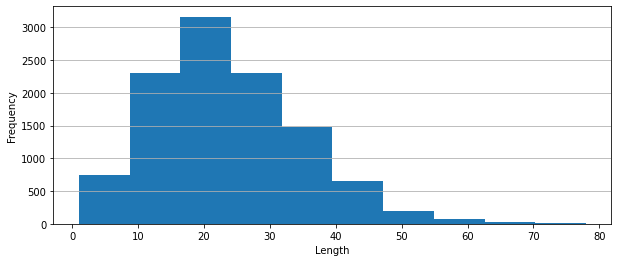

In [ ]:
length = []
for row in X_train:
  length.append(len(row.split()))
for row in X_test:
  length.append(len(row.split()))

mean = sum(length)/len(length)
print(f'''Mean = {mean}
Max = {max(length)}
Min = {min(length)}''')

plt.figure(figsize=(10, 4))
plt.hist(length)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [ ]:
embed_length = 50
output_dim = len(tag_to_idx)

In [ ]:
def convert_to_lower(text):
    # return the reviews after convering then to lowercase
    for i in range(len(text)):
        text[i] = text[i].lower()
    return text

In [ ]:
def remove_punctuation(text):
    # return the reviews after removing punctuations
    for i in range(len(text)):
        text[i] = re.sub(r'[^\w\s]', '', text[i])
    return text

In [ ]:
def perform_tokenization(text):
    # return the reviews after performing tokenization
    tokanized_text = []
    for i in range(len(text)):
        s = text[i].split()
        tokanized_text.append(s)
    return tokanized_text 

In [ ]:
def encode_data(text, vocab2index=None):
    if vocab2index is None:
        vocab2index = {"<PAD>":0, " ":1, "UNK":2}
        words = ["<PAD>", " ", "UNK"]
        for i in range(len(text)):
            s = text[i]
            for word in s:
                if word not in words:
                    vocab2index[word] = len(words)
                    words.append(word)

    for i in range(len(text)):
        s = text[i]
        enc_s = []
        for word in s:
            if word in vocab2index.keys():
                enc_s.append(vocab2index[word])
            else:
                enc_s.append(2)
        text[i] = enc_s
    
    return text, vocab2index

In [ ]:
def perform_padding(text, labels, maxLen=None):
    # return the reviews after padding the reviews to maximum 
    lengths = []
    if maxLen is None:
        maxLen = max([len(s) for s in text])

    for i in range(len(text)):
        l = len(text[i])
        lengths.append(l)
        zeros = []
        if l < maxLen:
            zeros = [0]*(maxLen-l)
        text[i] = text[i][:maxLen] + zeros
        labels[i] = labels[i][:maxLen] + zeros
    return torch.tensor(text).unsqueeze(1), torch.tensor(labels), torch.tensor(lengths), maxLen

In [ ]:
def preprocess_data(data, labels, vocab2index=None, maxLen=None):
    data = convert_to_lower(data)
    # data = remove_punctuation(data)
    data = perform_tokenization(data)
    data, vocab2index = encode_data(data, vocab2index)
    data, labels, lengths, maxLen = perform_padding(data, labels, maxLen)
    return data, labels, lengths, vocab2index, maxLen

In [ ]:
#@title Plot Grad Flow
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [ ]:
#@title Evaluate Function

def evaluate(X, y, model):
  model.eval()
  predictions = []
  labels = []
  loss_list = []
  batch_size = 32
  
  with torch.no_grad():
    for i in range(0, len(X), batch_size):
      x = Variable(X[i:i+batch_size])
      label = Variable(y[i:i+batch_size])

      out, _ = model(x)
      out = out.view(-1, out.shape[-1])
      label = label.view(-1)

      loss = F.cross_entropy(out, label)
      loss_list.append(loss.item())
      labels += label.cpu().detach().tolist()

      out = torch.max(out, 1)[1]
      predictions += out.cpu().detach().tolist()

  acc = accuracy_score(labels, predictions)
  return acc*100, np.mean(loss_list)/len(y)

In [ ]:
#@title Get Glove embeddings
embeddings_index = {}
f = open(f'../drive/My Drive/CS772/Assignment1/GloVe/glove.6B.{embed_length}d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Collecting {embed_length}d Glove embeddings')
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#@title Create Embedding Matrix
def create_embedding_matrix(vocab2index, embeddings_index):
    VOCAB_SIZE = len(vocab2index.keys())
    cnt = 0
    embedding_matrix = np.zeros((VOCAB_SIZE, embed_length))
    for word, i in vocab2index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            cnt += 1
    embedding_matrix = torch.Tensor(embedding_matrix)
    print(f"Number of words not found: {cnt}")
    return embedding_matrix

In [ ]:
#@title Create Embedding Layer
def create_emb_layer(weights_matrix, trainable=True):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if not trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer

In [ ]:
input = torch.randint(0, 50, (20, 78)).unsqueeze(1)
e = nn.Embedding(100, 50, padding_idx=0)
m = nn.Conv2d(1, 10, (5, 50), padding=(2,0))
e_out = e(input)
print(e_out.shape)
output = m(e_out)
print(output.shape)

torch.Size([20, 1, 78, 50])
torch.Size([20, 10, 78, 1])


In [ ]:
class CNNNet(nn.Module):
    def __init__(self, input_dim, context_window, z_dim, output_dim, 
                 embedding_matrix, pretrained_embed, trainable_embeddings):
        super(CNNNet, self).__init__()
        if pretrained_embed:
            self.embedding = create_emb_layer(embedding_matrix, trainable_embeddings)
        else:
            num_embeddings, embedding_dim = embedding_matrix.shape
            self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        
        self.conv = nn.Conv2d(1, z_dim, (context_window, input_dim), padding = (context_window//2, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(z_dim, output_dim)
        nn.init.normal_(self.fc.weight,0.0,1.0)
        
    def forward(self, x):
        out = self.embedding(x)
        out = self.conv(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = out[:,:,:,0]
        cnn_out = out.permute(0, 2, 1)
        out = self.fc(cnn_out)
        return out, cnn_out

In [ ]:
maxLen = None

X_train, y_train, l_train, vocab2index, maxLen = preprocess_data(X_train, y_train, maxLen=maxLen)
X_test, y_test, l_test, _, _ = preprocess_data(X_test, y_test, vocab2index, maxLen)

In [ ]:
datalen = len(X_train)
trainset_frac = 0.8
trainidx = int(datalen*trainset_frac)

X_train, y_train = shuffle(X_train, y_train)

train_data, train_label, train_lengths = X_train[:trainidx], y_train[:trainidx], l_train[:trainidx]
val_data, val_label, val_lengths = X_train[trainidx:], y_train[trainidx:], l_test[trainidx:]

In [ ]:
X_train, y_train = train_data.to(device), train_label.to(device)
X_val, y_val = val_data.to(device), val_label.to(device)

In [ ]:
class POS_Tagger():
    def __init__(self, X_train, y_train, l_train, X_val, y_val, l_val):
        super(POS_Tagger, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.l_train = l_train
        self.X_val = X_val
        self.y_val = y_val
        self.l_val = l_val

    def train(self, input_dim, context_window, z_dim, output_dim, vocab2index, 
              embeddings_index, pretrained_embed, trainable_embedding):    
        train_loss = []
        train_accu = []
        val_loss = []
        val_accu = []
        epoch_times = []
        train_los = 0.
        train_acc = 0.
        val_los = 0.
        val_acc = 0.

        X_train = self.X_train
        y_train = self.y_train
        l_train = self.l_train
        X_val = self.X_val
        y_val = self.y_val
        l_val = self.l_val

        print("######## Hyper Parameters #########")
        print("Learning Rate: {}".format(learn_rate))
        print("Batch Size: {}".format(batch_size))
        print("Num Epochs: {}".format(epochs))
        print("###################################")

        max_length = 30147

        embedding_matrix = create_embedding_matrix(vocab2index, embeddings_index)
        model = CNNNet(input_dim, context_window, z_dim, output_dim, embedding_matrix,
                       pretrained_embed, trainable_embedding).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

        print("Starting training the model")

        for epoch in range(1, epochs+1):
            start_time = time.perf_counter()
            avg_loss = 0.
            counter = 0  
            outs = []
            labels = []

            X_train, y_train = shuffle(X_train, y_train)
            
            train_labels = y_train.cpu().long().numpy()

            if sampling=="oversampling":
                indx= np.array([])
                for i in range(5):
                    idx = np.where(train_labels==i)[0]
                    mult = max_length//len(idx)
                    indx = np.append(indx, idx.repeat(mult))
                X_temp, y_temp = shuffle(X_train[indx], y_train[indx])              
            else:
                X_temp, y_temp = shuffle(X_train, y_train)
            
            X_temp, y_temp = shuffle(X_temp, y_temp)
            dataset_len = len(y_temp)

            for i in range(0, dataset_len, batch_size):
                if i + batch_size >= dataset_len:
                    plot_grad_flow(model.named_parameters())
                    break

                model.train()
                model.zero_grad()

                counter += batch_size

                x = Variable(X_temp[i:i+batch_size])
                label = Variable(y_temp[i:i+batch_size])

                out, _ = model(x)
                
                out = out.view(-1, out.shape[-1])
                label = label.view(-1)
                
                loss = criterion(out, label)
                avg_loss += loss.item()

                loss.backward()
                optimizer.step()

                out = torch.max(out, 1)[1]
                outs += out.cpu().detach().tolist()
                labels += label.cpu().detach().tolist()

            train_acc = accuracy_score(labels, outs)*100
            train_los = avg_loss/counter
            val_acc, val_los = evaluate(X_val, y_val, model)
            train_loss.append(train_los)
            train_accu.append(train_acc)
            val_loss.append(val_los)
            val_accu.append(val_acc)

            current_time = time.perf_counter()
            print("Epoch {}/{} Done | Train Loss: {:.3f} | Train Accu: {:.4f} | Val Loss: {:.3f} | Val Accu: {:.4f} | Time Elapsed: {:.2f}\n".format(epoch, epochs, avg_loss/counter, train_acc, val_los, val_acc, current_time-start_time))
            epoch_times.append(current_time-start_time)
        print("Total Training Time: {} seconds".format(sum(epoch_times)))

        plt.figure(figsize=(10,5))
        plt.subplot(121)
        plt.title("Training Loss")
        plt.plot(train_loss)

        plt.subplot(122)
        plt.title("Validation Loss")
        plt.plot(val_loss)

        plt.show()

        return model

In [ ]:
learn_rate, batch_size, epochs = 0.002, 128, 20

context_window = 5
z_dim = 32
pretrained_embed = True
trainable_embedding = True

sampling = "normal"

######## Hyper Parameters #########
Learning Rate: 0.002
Batch Size: 128
Num Epochs: 20
###################################
Number of words not found: 1467
Starting training the model


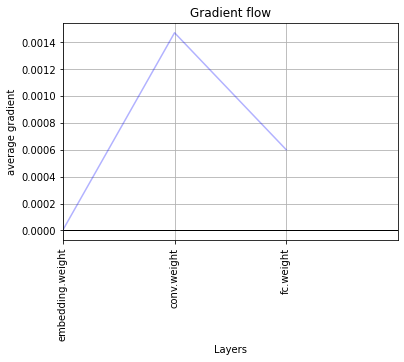

Epoch 1/20 Done | Train Loss: 0.013 | Train Accu: 65.7692 | Val Loss: 0.000 | Val Accu: 86.9350 | Time Elapsed: 2.29



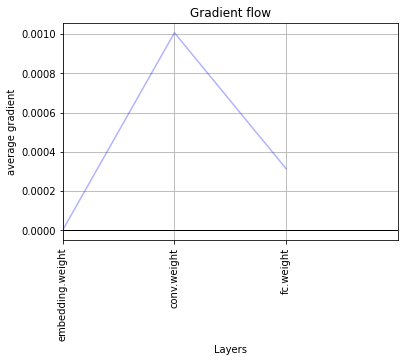

Epoch 2/20 Done | Train Loss: 0.004 | Train Accu: 87.2571 | Val Loss: 0.000 | Val Accu: 92.5178 | Time Elapsed: 1.93



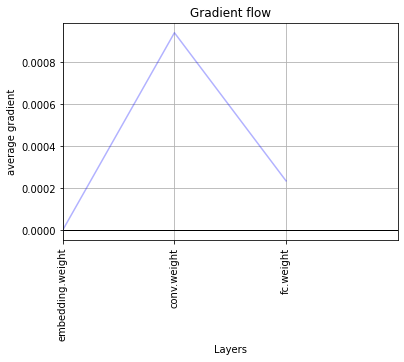

Epoch 3/20 Done | Train Loss: 0.002 | Train Accu: 91.5780 | Val Loss: 0.000 | Val Accu: 95.1586 | Time Elapsed: 1.98



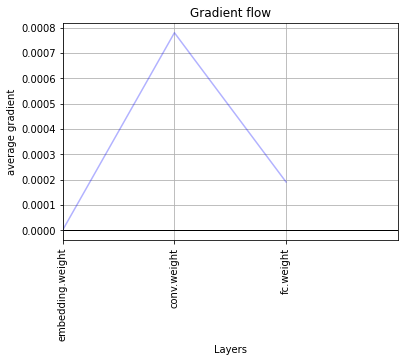

Epoch 4/20 Done | Train Loss: 0.002 | Train Accu: 93.9705 | Val Loss: 0.000 | Val Accu: 96.5532 | Time Elapsed: 1.94



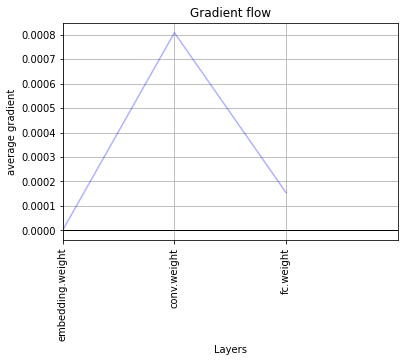

Epoch 5/20 Done | Train Loss: 0.001 | Train Accu: 95.4349 | Val Loss: 0.000 | Val Accu: 97.2817 | Time Elapsed: 1.93



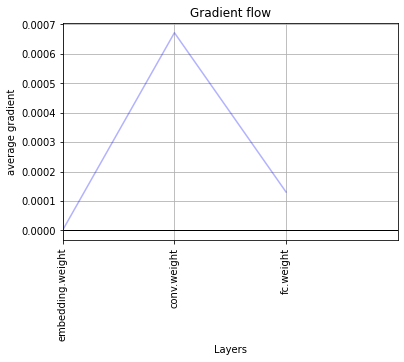

Epoch 6/20 Done | Train Loss: 0.001 | Train Accu: 96.3811 | Val Loss: 0.000 | Val Accu: 97.7313 | Time Elapsed: 1.95



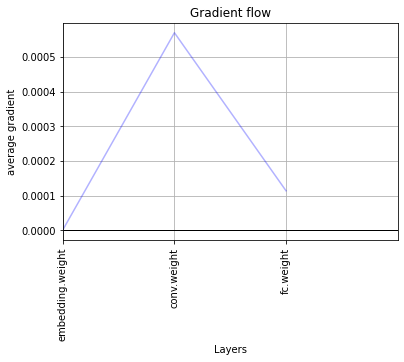

Epoch 7/20 Done | Train Loss: 0.001 | Train Accu: 97.0442 | Val Loss: 0.000 | Val Accu: 98.0117 | Time Elapsed: 1.94



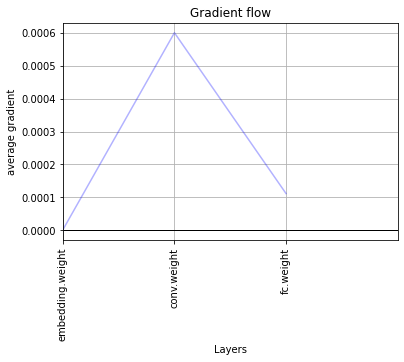

Epoch 8/20 Done | Train Loss: 0.001 | Train Accu: 97.4909 | Val Loss: 0.000 | Val Accu: 98.1522 | Time Elapsed: 1.95



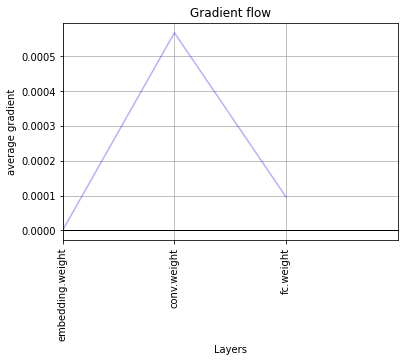

Epoch 9/20 Done | Train Loss: 0.001 | Train Accu: 97.8405 | Val Loss: 0.000 | Val Accu: 98.2899 | Time Elapsed: 1.93



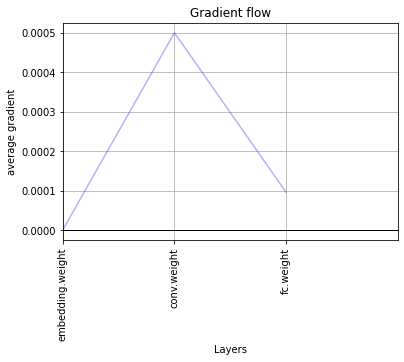

Epoch 10/20 Done | Train Loss: 0.001 | Train Accu: 98.1086 | Val Loss: 0.000 | Val Accu: 98.3709 | Time Elapsed: 1.93



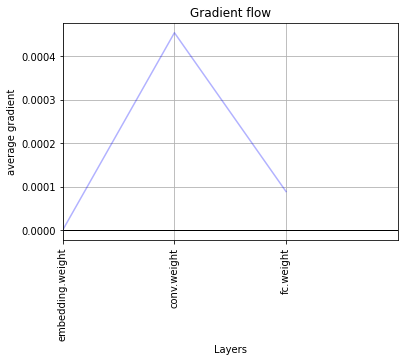

Epoch 11/20 Done | Train Loss: 0.000 | Train Accu: 98.2794 | Val Loss: 0.000 | Val Accu: 98.4096 | Time Elapsed: 1.93



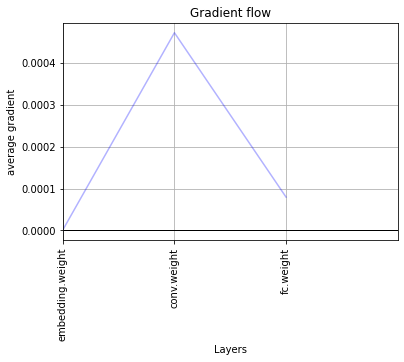

Epoch 12/20 Done | Train Loss: 0.000 | Train Accu: 98.4788 | Val Loss: 0.000 | Val Accu: 98.4620 | Time Elapsed: 1.95



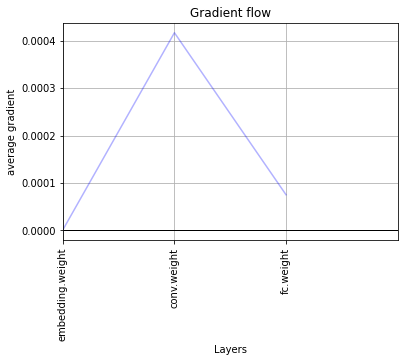

Epoch 13/20 Done | Train Loss: 0.000 | Train Accu: 98.6247 | Val Loss: 0.000 | Val Accu: 98.4878 | Time Elapsed: 1.95



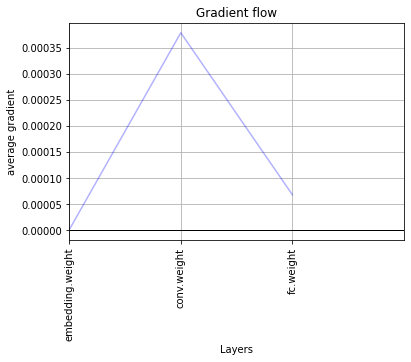

Epoch 14/20 Done | Train Loss: 0.000 | Train Accu: 98.7713 | Val Loss: 0.000 | Val Accu: 98.5122 | Time Elapsed: 2.00



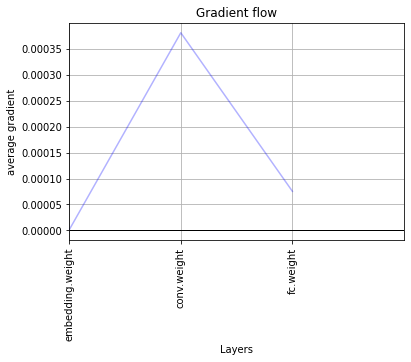

Epoch 15/20 Done | Train Loss: 0.000 | Train Accu: 98.8749 | Val Loss: 0.000 | Val Accu: 98.5437 | Time Elapsed: 1.95



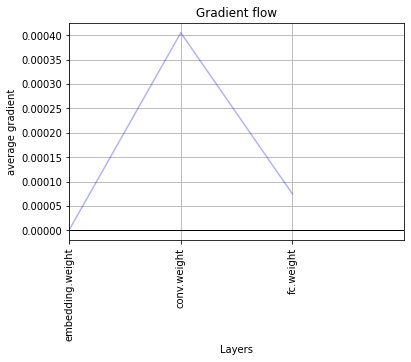

Epoch 16/20 Done | Train Loss: 0.000 | Train Accu: 98.9636 | Val Loss: 0.000 | Val Accu: 98.5581 | Time Elapsed: 1.98



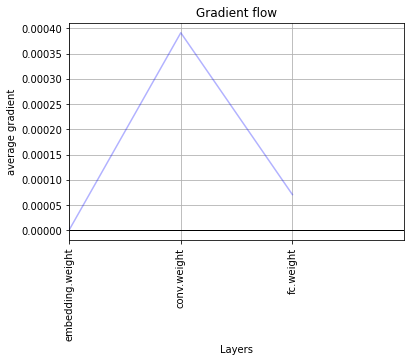

Epoch 17/20 Done | Train Loss: 0.000 | Train Accu: 99.0554 | Val Loss: 0.000 | Val Accu: 98.5968 | Time Elapsed: 1.96



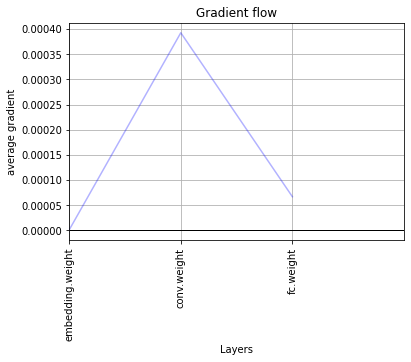

Epoch 18/20 Done | Train Loss: 0.000 | Train Accu: 99.1095 | Val Loss: 0.000 | Val Accu: 98.6125 | Time Elapsed: 2.12



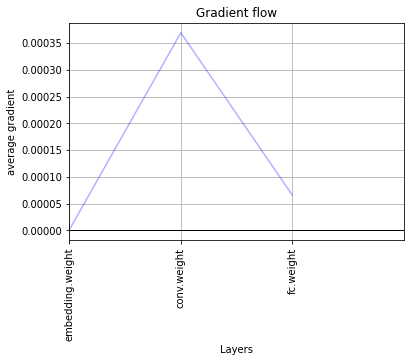

Epoch 19/20 Done | Train Loss: 0.000 | Train Accu: 99.1752 | Val Loss: 0.000 | Val Accu: 98.6018 | Time Elapsed: 1.96



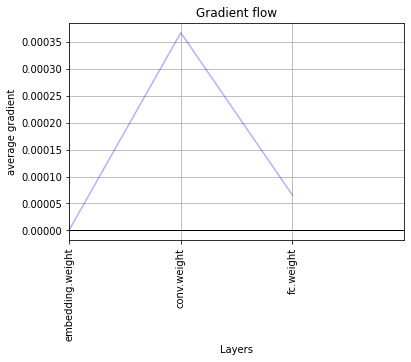

Epoch 20/20 Done | Train Loss: 0.000 | Train Accu: 99.2519 | Val Loss: 0.000 | Val Accu: 98.6097 | Time Elapsed: 1.98

Total Training Time: 39.54327754800016 seconds


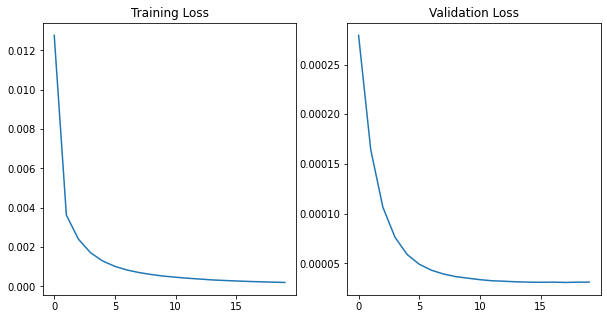

In [ ]:
tagger = POS_Tagger(X_train, y_train, train_lengths, X_val, y_val, val_lengths)
model = tagger.train(embed_length, context_window, z_dim, output_dim, vocab2index, 
              embeddings_index, pretrained_embed, trainable_embedding)

In [ ]:
X_test, y_test = X_test.to(device), y_test.to(device)

test_acc, test_los = evaluate(X_test, y_test, model)
print(test_acc)

98.1610337972167


In [ ]:
def test(X, y, model):
    model.eval()
    cnn_outs = []
    predictions = []
    labels = []
    batch_size = 64

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            x = Variable(X[i:i+batch_size])
            label = Variable(y[i:i+batch_size])

            out, cnn_out = model(x)
            out = out.view(-1, out.shape[-1])
            label = label.view(-1)

            cnn_out = cnn_out.reshape(-1, cnn_out.shape[-1])
            cnn_outs += cnn_out.cpu().detach().tolist()

            preds = torch.max(out, 1)[1]
            predictions += preds.cpu().detach().tolist()
            labels += label.cpu().detach().tolist()

    return predictions, labels, cnn_outs

In [ ]:
preds, label, _ = test(X_test, y_test, model)
cm = confusion_matrix(label, preds)
f = f1_score(label, preds, average=None)
print(cm)
print(f)

[[109559      0      0 ...      0      0      0]
 [     1   6226      1 ...      0      0      0]
 [     0      2   5041 ...      0      0      0]
 ...
 [     0      2      0 ...      1      0      0]
 [     0      0      0 ...      0      3      0]
 [     0      1      0 ...      0      0      0]]
[0.99993611 0.89019159 0.99154209 0.99429139 0.93499152 0.94728916
 0.86142662 1.         0.9293709  0.87784471 0.91633604 0.87096097
 0.999741   0.99793814 0.9954023  0.89803922 0.8812095  1.
 0.95952509 0.93095094 0.97959184 0.98633018 0.64516129 0.99938537
 0.90410959 1.         0.77419355 0.92048193 0.88431877 0.99459459
 0.96       0.         0.4        0.4        0.85714286 0.        ]


In [ ]:
new_labels = []
new_preds = []
for i in range(len(label)):
    if label[i] != 0 and label[i] != tag_to_idx["PUN"]:
        new_labels.append(label[i])
        new_preds.append(preds[i])

acc = accuracy_score(new_labels, new_preds)*100
cm = confusion_matrix(new_labels, new_preds)
f = f1_score(new_labels, new_preds, average=None)

print(acc)
print(f)

93.06256913384313
[0.         0.89019159 0.99154209 0.99429139 0.93499152 0.94728916
 0.86142662 1.         0.9293709  0.87784471 0.91633604 0.87096097
 0.         0.99793814 0.99654776 0.89803922 0.8812095  1.
 0.95952509 0.93095094 0.97959184 0.98633018 0.64516129 0.99938537
 0.90410959 1.         0.77419355 0.92048193 0.88431877 0.99459459
 0.96       0.         0.4        0.4        0.85714286 0.        ]


In [ ]:
POS_tags_test = {}
for line in y_test_tags:
    s = line.split()
    for elem in s:
        if elem not in POS_tags_test:
            POS_tags_test[elem] = 1
        else:
            POS_tags_test[elem] += 1
print(len(POS_tags_test))
print(POS_tags_test)

35
{'NNP': 4806, 'POS': 434, 'NN': 6642, 'VBD': 1679, 'PRP': 814, 'DT': 4020, 'JJ': 2964, 'VBG': 728, 'PRP$': 421, 'IN': 5071, 'TO': 1178, 'VB': 1269, 'NNS': 3034, 'CD': 1918, 'PUN': 5791, 'VBZ': 913, 'VBP': 539, 'VBN': 1104, 'CC': 1214, 'RB': 1354, 'WDT': 202, 'WP': 110, 'RBR': 71, 'JJR': 202, 'NNPS': 130, 'MD': 470, 'WRB': 93, 'JJS': 77, 'EX': 48, 'WP$': 4, 'RP': 12, 'UH': 2, 'RBS': 49, 'FW': 4, 'PDT': 10}


In [ ]:
def tag_sentence(data, vocab2index, model):
    model.eval()
    data = convert_to_lower(data)
    # data = remove_punctuation(data)
    data = perform_tokenization(data)
    data, vocab2index = encode_data(data, vocab2index)
    data = Variable(torch.tensor(data)).to(device).unsqueeze(1)
    out, cnn_out = model(data)
    out = out.view(-1, out.shape[-1])
    preds = torch.max(out, 1)[1]
    tags = [idx_to_tag[int(x)] for x in preds]
    return tags, cnn_out.cpu().detach().numpy()

In [ ]:
s = ["Delhi is the capital of India ."]
tags, cnn_out = tag_sentence(s, vocab2index, model)
for i in range(len(tags)):
    print(f"{s[0].split()[i]}\t:\t{tags[i]}")

delhi	:	NN
is	:	VBZ
the	:	DT
capital	:	NN
of	:	IN
india	:	NNP
.	:	PUN


In [ ]:
_, train_labels, train_cnn_outs = test(X_train, y_train, model)
_, val_labels, val_cnn_outs = test(X_val, y_val, model)

train_labels = np.append(train_labels, val_labels, axis=0)
train_cnn_outs = np.append(train_cnn_outs, val_cnn_outs, axis=0) 

_, test_labels, test_cnn_outs = test(X_test, y_test, model)

In [ ]:
print(train_labels.shape)
print(train_cnn_outs.shape)

(697008,)
(697008, 32)


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
#@title Predict Function
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import math

def predict(X_tfinal, labels, sklearn_obj):
  clf = sklearn_obj
  predictions = clf.predict(X_tfinal)

  print("Accuracy = {:.3f}".format(accuracy_score(labels, predictions)))
  print(f1_score(labels, predictions, average=None))
  print(confusion_matrix(labels, predictions))
  return predictions, labels

In [ ]:
svm_clf = SVC()
svm_clf.fit(train_cnn_outs, train_labels)

print("Classifier: SVM")
svm_preds, svm_labels = predict(test_cnn_outs, test_labels, svm_clf)

Classifier: SVM
Accuracy = 0.982
[0.99995436 0.89610484 0.99183312 0.99527716 0.94170911 0.95062194
 0.86904762 1.         0.93322981 0.87283891 0.91803279 0.87593078
 0.99991365 0.99834983 0.99770115 0.91187739 0.88583815 1.
 0.96813922 0.93569712 0.97959184 0.98739496 0.66079295 0.99938537
 0.91034483 1.         0.79389313 0.92420538 0.90862944 0.99459459
 0.95049505 0.75       0.35294118 0.4        1.         0.        ]
[[109559      0      0 ...      0      0      0]
 [     1   6154      1 ...      0      0      0]
 [     0      1   5040 ...      0      0      0]
 ...
 [     0      2      0 ...      1      0      0]
 [     0      0      0 ...      0      4      0]
 [     0      1      0 ...      0      0      0]]


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=-1)
rf_clf.fit(train_cnn_outs, train_labels)

print("\nClassifier: Random Forest")
rf_preds, rf_labels = predict(test_cnn_outs, test_labels, rf_clf)


Classifier: Random Forest
Accuracy = 0.982
[0.99998175 0.8996337  0.9927194  0.99478131 0.93746479 0.95399698
 0.85950413 1.         0.93805999 0.86915737 0.91780114 0.87068074
 0.99991365 0.99834983 0.99654776 0.91241578 0.88214027 1.
 0.9631016  0.93413897 0.98969072 0.9904963  0.63348416 0.99938537
 0.92517007 1.         0.80916031 0.92909535 0.90816327 0.99459459
 0.96907216 0.66666667 0.44444444 0.         1.         0.        ]
[[109559      0      0 ...      0      0      0]
 [     1   6140      1 ...      0      0      0]
 [     0      1   5045 ...      0      0      0]
 ...
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      4      0]
 [     0      0      0 ...      0      0      0]]


In [ ]:
def metric_values(preds, labels):
    new_labels = []
    new_preds = []
    for i in range(len(labels)):
        if labels[i] != 0 and labels[i] != tag_to_idx["PUN"]:
            new_labels.append(labels[i])
            new_preds.append(preds[i])

    acc = accuracy_score(new_labels, new_preds)*100
    cm = confusion_matrix(new_labels, new_preds)
    f = f1_score(new_labels, new_preds, average=None)

    print(acc)
    print(f)

In [ ]:
print("Metrics for SVM Classifier:")
metric_values(svm_preds, svm_labels)

print("\nMetrics for Random Forest Classifier:")
metric_values(rf_preds, rf_labels)

Metrics for SVM Classifier:
93.37757899293031
[0.         0.89610484 0.99183312 0.99527716 0.94170911 0.95062194
 0.86904762 1.         0.93322981 0.87283891 0.91803279 0.87593078
 0.99834983 0.99884925 0.91187739 0.88583815 1.         0.96813922
 0.93569712 0.97959184 0.98739496 0.66079295 0.99938537 0.91034483
 1.         0.79389313 0.92420538 0.90862944 0.99459459 0.95049505
 0.75       0.35294118 0.4        1.         0.        ]

Metrics for Random Forest Classifier:
93.31746260760832
[0.         0.8996337  0.9927194  0.99478131 0.93746479 0.95399698
 0.85950413 1.         0.93805999 0.86915737 0.91780114 0.87068074
 0.99834983 0.99769585 0.91241578 0.88214027 1.         0.9631016
 0.93413897 0.98969072 0.9904963  0.63348416 0.99938537 0.92517007
 1.         0.80916031 0.92909535 0.90816327 0.99459459 0.96907216
 0.66666667 0.44444444 0.         1.         0.        ]


In [ ]:
preds = svm_clf.predict(cnn_out.squeeze())
tags = [idx_to_tag[int(x)] for x in preds]
for i in range(len(tags)):
    print(f"{s[0].split()[i]}\t:\t{tags[i]}")

hello	:	NNP
,	:	PUN
my	:	PRP$
name	:	NN
is	:	VBZ
shyam	:	JJ
and	:	CC
i	:	PRP
am	:	VBP
a	:	DT
student	:	NN
at	:	IN
epfl	:	NNP
in	:	IN
europe	:	NNP
.	:	PUN


In [ ]:
preds = rf_clf.predict(cnn_out.squeeze())
tags = [idx_to_tag[int(x)] for x in preds]
for i in range(len(tags)):
    print(f"{s[0].split()[i]}\t:\t{tags[i]}")

hello	:	NNP
,	:	PUN
my	:	PRP$
name	:	NN
is	:	VBZ
shyam	:	NNP
and	:	CC
i	:	PRP
am	:	VBP
a	:	DT
student	:	NN
at	:	IN
epfl	:	NNP
in	:	IN
europe	:	NNP
.	:	PUN
